In [93]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../../..'))

%load_ext autoreload
%autoreload 2

import numba
import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn import model_selection

import matplotlib.pyplot as plt
import seaborn as sns
from models import model_interface, model_loader, model_constants
from recourse_methods import mrmc_method
from data import data_loader
from data.adapters import continuous_adapter
from confidence_checks import plotting_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
DATASET, DATASET_INFO = data_loader.load_data(data_loader.DatasetName('credit_card_default'))
MODEL = model_loader.load_model(model_constants.ModelType('logistic_regression'), data_loader.DatasetName('credit_card_default'))
ADAPTER = continuous_adapter.StandardizingAdapter(
    label_column = DATASET_INFO.label_column, positive_label=DATASET_INFO.positive_label
).fit(DATASET)


transformed_data = ADAPTER.transform(DATASET.drop(columns='Y')).sample(frac=1, replace=False)
best_bandwidth = 0.251188643150958
KDE = neighbors.KernelDensity(bandwidth=best_bandwidth).fit(transformed_data)

/home/jakeval/umass/research/.venv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jakeval/umass/research/.venv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [314]:
def generate_clusters(num_clusters, confidence_threshold, cluster_seed, outlier=None):
    data = DATASET
    if outlier is not None:
        maxval = np.abs(ADAPTER.transform(DATASET.drop(columns="Y"))).max(axis=1)
        data = data[maxval < 20]
    mrmc = mrmc_method.MRMC(
        k_directions=num_clusters,
        adapter=ADAPTER,
        dataset=data,
        confidence_threshold=confidence_threshold,
        model=MODEL,
        random_seed=cluster_seed
    )
    return mrmc.clusters, data


CLUSTER_SEED = 1834823
DATASET_COLUMNS = DATASET.drop(columns='Y').columns

# Clusters for k=3, c=None

In [154]:
k_clusters = 3
confidence = None
clusters, _ = generate_clusters(k_clusters, confidence, CLUSTER_SEED)
clusters.cluster_assignments.groupby('datapoint_cluster').count()

,datapoint_index
datapoint_cluster,
0,14537
1,4094
2,926


## These clusters seem reasonable

* All clusters pay a little earlier than the average. (value of around 0.3, which means less than a month late)
* __Cluster 0__ is close to the average (and slightly below it) for every field.
  * "Be less late. Spend less. Pay just a little less."
* __Cluster 1__ is close to the average and slightly above it for the pay and bill fields.
  * "Be less late. Spend more. Pay more. Increase your credit limit."
* __Cluster 2__ is well above the average for the pay and bill fields.
  * "Be less late. Be older. Have a big credit limit. Spend a lot more. Pay a lot more."

In [164]:
cluster_centers = pd.DataFrame(columns=DATASET_COLUMNS, data=clusters.cluster_centers)
cluster_centers

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-0.020303,-0.048984,-0.455685,-0.363750,-0.302387,-0.273107,-0.270666,-0.247939,-0.371817,-0.391225,-0.398222,-0.407828,-0.407617,-0.403246,-0.085110,-0.064725,-0.081811,-0.083119,-0.081547,-0.059518
1,0.516906,0.041586,-0.455262,-0.394616,-0.320659,-0.287679,-0.254849,-0.232357,0.892474,0.907969,0.891026,0.896390,0.887610,0.889110,0.444421,0.300558,0.389967,0.401808,0.424744,0.305301
2,1.494532,0.308287,-0.456292,-0.393798,-0.327243,-0.286073,-0.263481,-0.238195,2.996749,3.107056,3.243703,3.246777,3.201201,3.108737,1.247525,1.097843,0.940716,0.901096,0.755244,0.878857


### Plotting -- whoops there's outliers

Should I filter these before creating the clusters? Probably -- MRMC should have options for removing outliers.

Until then, I'll keep them but remove them from the visualization.

Text(0.5, 1.0, "Wow there's some outliers")

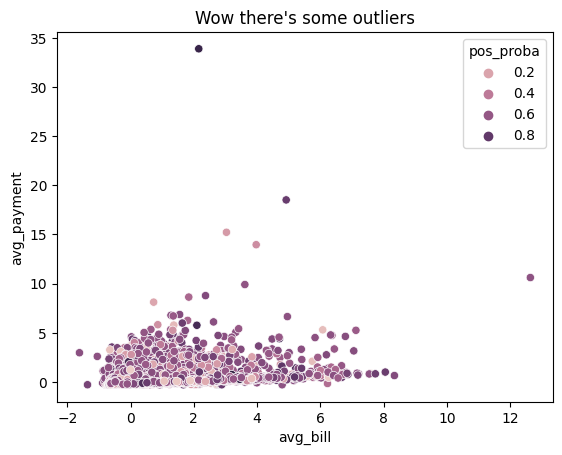

In [160]:
LATE_COLUMNS = [f"PAY_{i}" for i in range(1, 7)]
BILL_COLUMNS = [f"BILL_AMT{i}" for i in range(1, 7)]
PAY_COLUMNS = [f"PAY_AMT{i}" for i in range(1, 7)]

pos_proba = MODEL.predict_pos_proba(DATASET)
viz_data = ADAPTER.transform(DATASET).copy()
viz_data['datapoint_index'] = viz_data.index
viz_data = viz_data.merge(clusters.cluster_assignments, how='left', on='datapoint_index')
viz_data = viz_data.drop(columns='datapoint_index')

viz_data['avg_payment'] = viz_data[PAY_COLUMNS].mean(axis=1)
viz_data['avg_bill'] = viz_data[BILL_COLUMNS].mean(axis=1)
viz_data['pos_proba'] = pos_proba
viz_data['classification'] = MODEL.predict(DATASET)

sns.scatterplot(viz_data, x='avg_bill', y='avg_payment', hue='pos_proba')
plt.title("Wow there's some outliers")

Text(0.5, 1.0, 'No more outliers')

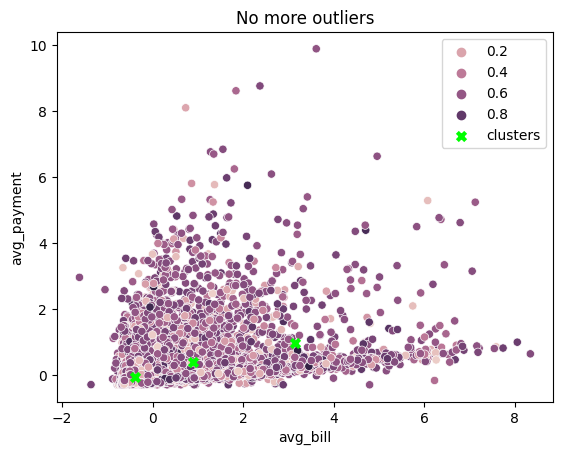

In [161]:
viz_clusters = cluster_centers.copy()
viz_clusters['avg_payment'] = viz_clusters[PAY_COLUMNS].mean(axis=1)
viz_clusters['avg_bill'] = viz_clusters[BILL_COLUMNS].mean(axis=1)


viz_data = viz_data[viz_data.avg_bill < 10]
viz_data = viz_data[viz_data.avg_payment < 10]
sns.scatterplot(viz_data, x='avg_bill', y='avg_payment', hue='pos_proba')
plt.scatter(viz_clusters['avg_bill'], viz_clusters['avg_payment'], marker='x', c='lime', linewidths=3, label='clusters')
plt.legend()
plt.title("No more outliers")

Text(0.5, 1.0, 'Only True Positives')

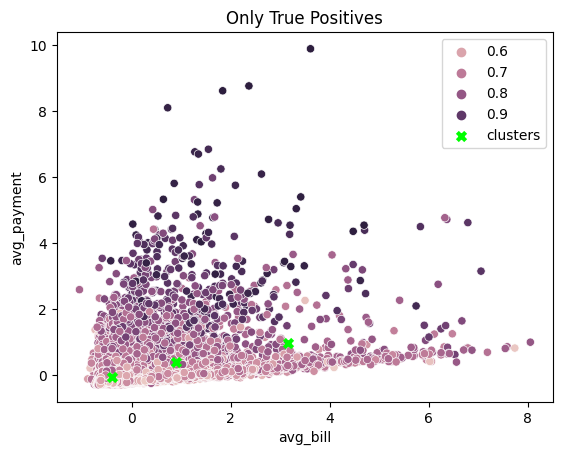

In [158]:
sns.scatterplot(viz_data[(viz_data.Y == 1) & (viz_data.classification == 0)], x='avg_bill', y='avg_payment', hue='pos_proba')
plt.scatter(viz_clusters['avg_bill'], viz_clusters['avg_payment'], marker='x', c='lime', linewidths=3, label='clusters')
plt.legend()
plt.title("Only True Positives")

Text(0.5, 1.0, 'Only True Positives')

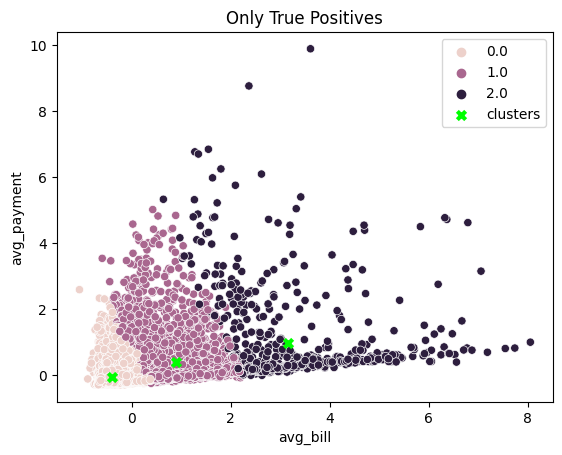

In [162]:
sns.scatterplot(viz_data[(viz_data.Y == 1) & (viz_data.classification == 0)], x='avg_bill', y='avg_payment', hue='datapoint_cluster')
plt.scatter(viz_clusters['avg_bill'], viz_clusters['avg_payment'], marker='x', c='lime', linewidths=3, label='clusters')
plt.legend()
plt.title("Only True Positives")

## Cluster densities

hist plot of KDEs of assigned points

Text(0.5, 1.0, 'Cluster 0 densities')

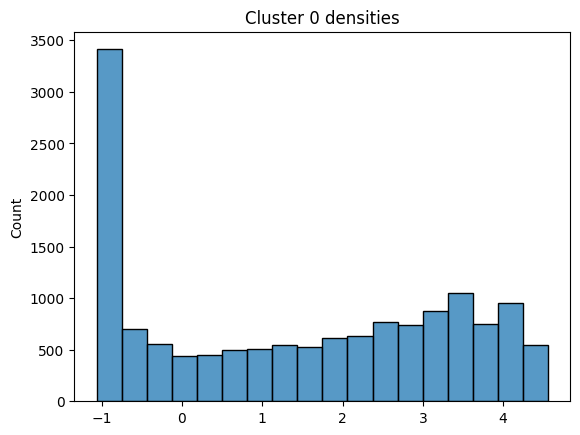

In [202]:
cluster_index = 0
cluster_center = cluster_centers.iloc[cluster_index].to_numpy()

scores = KDE.score_samples(viz_data[viz_data.datapoint_cluster == cluster_index].drop(columns=['Y', 'avg_payment', 'avg_bill', 'pos_proba', 'classification', 'datapoint_cluster']))

sns.histplot(scores)
plt.title("Cluster 0 densities")

Text(0.5, 1.0, 'Cluster 1 densities')

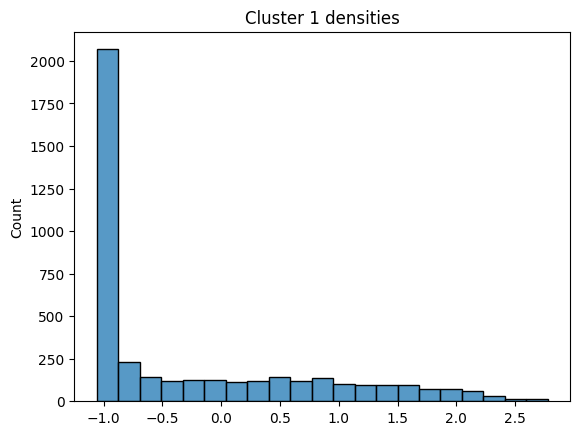

In [203]:
cluster_index = 1
cluster_center = cluster_centers.iloc[cluster_index].to_numpy()

scores = KDE.score_samples(viz_data[viz_data.datapoint_cluster == cluster_index].drop(columns=['Y', 'avg_payment', 'avg_bill', 'pos_proba', 'classification', 'datapoint_cluster']))

sns.histplot(scores)
plt.title("Cluster 1 densities")

Text(0.5, 1.0, 'Cluster 2 densities')

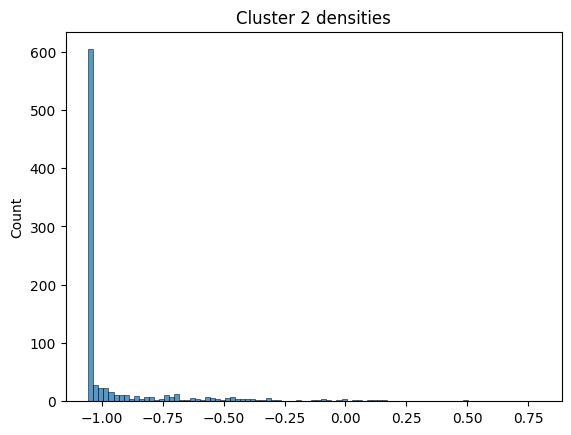

In [204]:
cluster_index = 2
cluster_center = cluster_centers.iloc[cluster_index].to_numpy()

scores = KDE.score_samples(viz_data[viz_data.datapoint_cluster == cluster_index].drop(columns=['Y', 'avg_payment', 'avg_bill', 'pos_proba', 'classification', 'datapoint_cluster']))

sns.histplot(scores)
plt.title("Cluster 2 densities")

# Clusters for k=3, c=0.7

In [230]:
k_clusters = 3
confidence = 0.7
clusters, _ = generate_clusters(k_clusters, confidence, CLUSTER_SEED)
clusters.cluster_assignments.groupby('datapoint_cluster').count()

,datapoint_index
datapoint_cluster,
0,909
1,3520
2,4


## These cluster's aren't reasonable.

* All clusters pay a little earlier than the average
* __Cluster 0__ is consistently above average in other columns
* __Cluster 1__ is below average in BILL_AMT and above average in PAY_AMT
* __Cluster 2__ is overfit for some outliers
  * BILL_AMT is mostly normal
    * BILL_AMT3 is 10!
    * BILL_AMT6 is 3
  * PAY_AMT is not normal
    * Ranges from 2 (normal) to 55 (wtf)

In [231]:
cluster_centers = pd.DataFrame(columns=DATASET_COLUMNS, data=clusters.cluster_centers)
cluster_centers

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1.607875,0.058558,-0.451733,-0.395074,-0.351254,-0.322664,-0.302497,-0.279824,2.503046,2.593196,2.671757,2.781147,2.866921,2.848760,1.514295,1.086941,1.216964,1.126540,1.045186,1.015588
1,1.307876,-0.078289,-0.462346,-0.391034,-0.378863,-0.328789,-0.305454,-0.305566,-0.199365,-0.200647,-0.176596,-0.159393,-0.113047,-0.086701,0.601215,0.449454,0.448321,0.507084,0.488648,0.534262
2,1.464526,0.001573,-0.469071,-0.399186,-0.384614,-0.339990,-0.308621,-0.316688,0.183038,1.556448,10.545461,1.239264,1.313436,3.077778,20.359179,55.637317,16.402596,11.178862,8.359221,2.393758


Text(0.5, 1.0, 'Only True Positives')

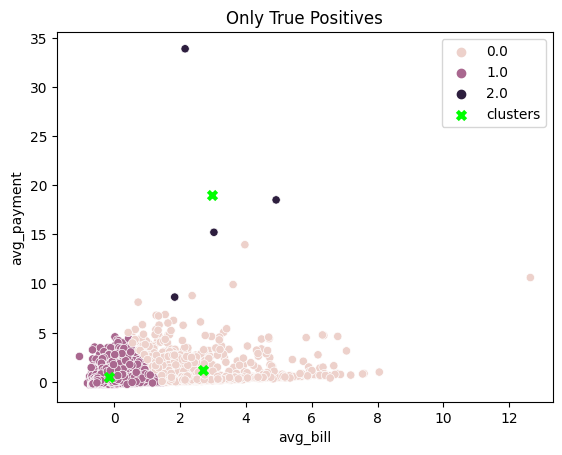

In [236]:
viz_data = ADAPTER.transform(DATASET).copy()
viz_data['pos_proba'] = pos_proba
viz_data['classification'] = MODEL.predict(DATASET)

viz_data['datapoint_index'] = viz_data.index
viz_data = viz_data.merge(clusters.cluster_assignments, how='left', on='datapoint_index')
viz_data = viz_data.drop(columns='datapoint_index')

viz_data['avg_payment'] = viz_data[PAY_COLUMNS].mean(axis=1)
viz_data['avg_bill'] = viz_data[BILL_COLUMNS].mean(axis=1)

viz_clusters = cluster_centers.copy()
viz_clusters['avg_payment'] = viz_clusters[PAY_COLUMNS].mean(axis=1)
viz_clusters['avg_bill'] = viz_clusters[BILL_COLUMNS].mean(axis=1)

sns.scatterplot(viz_data[(viz_data.Y == 1) & (viz_data.classification == 0)], x='avg_bill', y='avg_payment', hue='datapoint_cluster')
plt.scatter(viz_clusters['avg_bill'], viz_clusters['avg_payment'], marker='x', c='lime', linewidths=3, label='clusters')
plt.legend()
plt.title("Only True Positives")

# Removing outliers

## Can we use KDE scores?

Probably not, it seems most points have the minimum density score. Which, as an aside, seems suspicious.

In [216]:
kde_scores = KDE.score_samples(ADAPTER.transform(DATASET.drop(columns='Y')))

<AxesSubplot: ylabel='Count'>

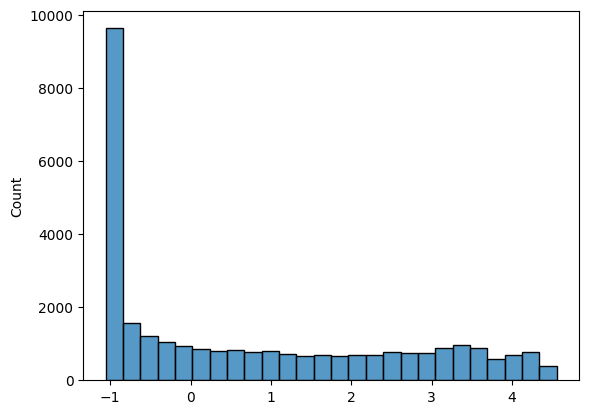

In [223]:
sns.histplot(kde_scores)

<AxesSubplot: ylabel='Count'>

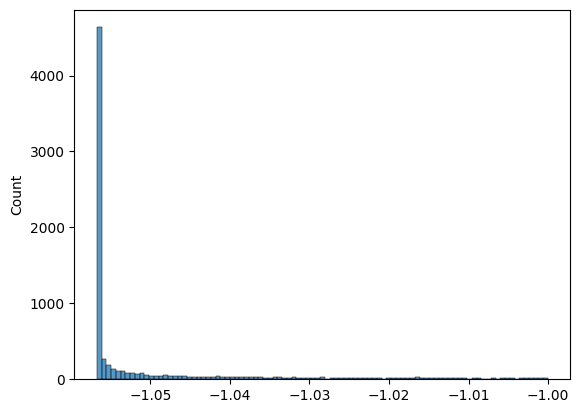

In [260]:
sns.histplot(kde_scores[kde_scores <= -1])

## Try removing rows with large values

Just try removing points with high values lol.

The histograms for maximum feature Z-score look reasonable. They aren't normally distributed, but there's a clear tail. 

<AxesSubplot: xlabel='maxval', ylabel='Count'>

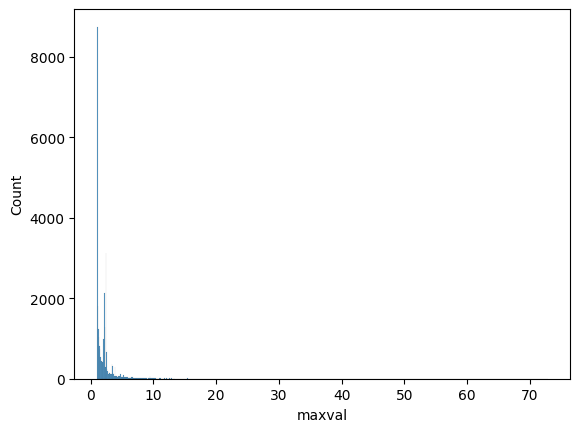

In [279]:
data = ADAPTER.transform(DATASET).copy()
data['maxval'] = np.abs(data).max(axis=1)
sns.histplot(data, x='maxval')

<AxesSubplot: xlabel='maxval', ylabel='Count'>

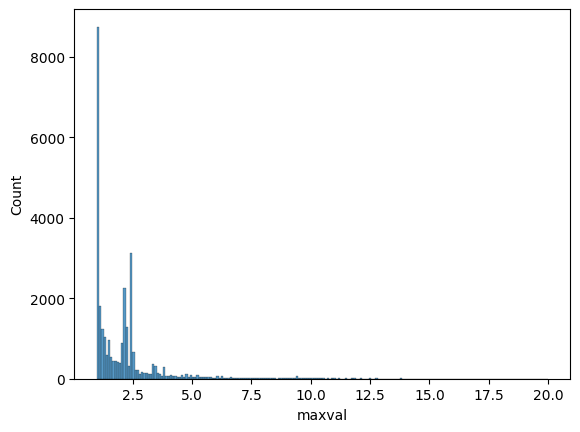

In [299]:
sns.histplot(data[data.maxval < 20], x='maxval')  # 20 seems conservative

### 20 Seems like a reasonable value

The histplots show there are very few points with maximums greater than 10, but we can choose 20 out of abundance of caution.

There are only 37 points with values greater than 20.

The columns containing these outlier values are:
* BILL_AMT3
* PAY_AMT[1 - 6]

In [312]:
outliers = data[data.maxval > 20].drop(columns=['Y', 'maxval', 'outlier', 'avg_payment', 'avg_bill'])
outliers.columns[(np.abs(outliers) > 20).any()]

Index(['BILL_AMT3', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6'],
      dtype='object')

In [296]:
data[data.maxval > 20].shape

(37, 25)

Text(0.5, 1.0, 'These Points Have Got to Go')

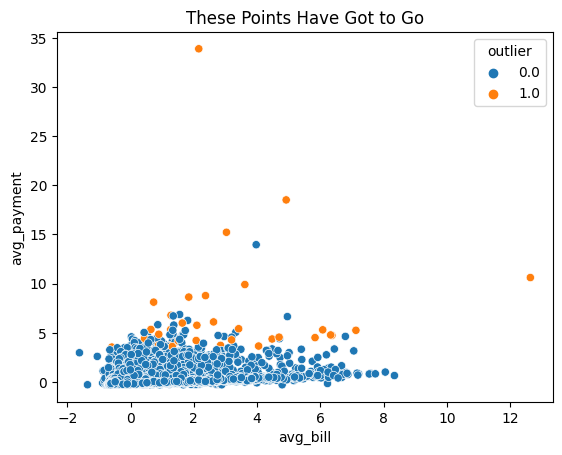

In [284]:
data['outlier'] = (data.maxval > 20).astype(np.float64)
data['avg_payment'] = data[PAY_COLUMNS].mean(axis=1)
data['avg_bill'] = data[BILL_COLUMNS].mean(axis=1)

sns.scatterplot(data, x='avg_bill', y='avg_payment', hue='outlier')
plt.title("These Points Have Got to Go")

# Clusters without outliers (k=3, c=0.7)

Wow! This fixes the issues.

In [313]:
k_clusters = 3
confidence = 0.7
clusters, dataset = generate_clusters(k_clusters, confidence, CLUSTER_SEED, outlier=20)
clusters.cluster_assignments.groupby('datapoint_cluster').count()

,datapoint_index
datapoint_cluster,
0,3140
1,683
2,577


In [293]:
cluster_centers = pd.DataFrame(columns=DATASET_COLUMNS, data=clusters.cluster_centers)
cluster_centers

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1.313324,-0.105946,-0.466140,-0.390050,-0.383003,-0.329111,-0.305072,-0.306895,-0.217604,-0.248647,-0.205508,-0.204097,-0.187795,-0.180085,0.380531,0.389417,0.276463,0.245830,0.257893,0.417911
1,1.668185,0.036597,-0.467146,-0.395534,-0.366094,-0.316906,-0.304541,-0.296223,2.960408,2.926408,3.036577,3.061872,3.121318,3.103382,0.547514,0.899970,0.442931,0.448117,0.543231,0.625362
2,1.273411,0.134972,-0.428055,-0.397025,-0.336386,-0.330882,-0.303792,-0.268238,0.329565,0.643481,0.544323,0.752551,0.998530,1.094292,3.094053,1.149629,2.311690,2.695147,2.277090,1.534735


Text(0.5, 1.0, 'Only True Positives')

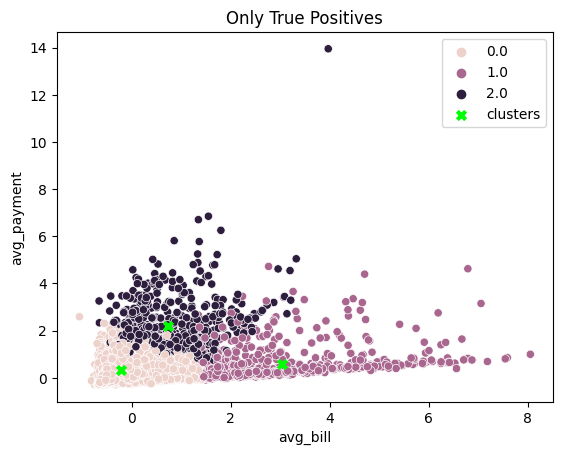

In [295]:
viz_data = ADAPTER.transform(dataset).copy()
viz_data['pos_proba'] = pos_proba
viz_data['classification'] = MODEL.predict(dataset)

viz_data['datapoint_index'] = viz_data.index
viz_data = viz_data.merge(clusters.cluster_assignments, how='left', on='datapoint_index')
viz_data = viz_data.drop(columns='datapoint_index')

viz_data['avg_payment'] = viz_data[PAY_COLUMNS].mean(axis=1)
viz_data['avg_bill'] = viz_data[BILL_COLUMNS].mean(axis=1)

viz_clusters = cluster_centers.copy()
viz_clusters['avg_payment'] = viz_clusters[PAY_COLUMNS].mean(axis=1)
viz_clusters['avg_bill'] = viz_clusters[BILL_COLUMNS].mean(axis=1)

sns.scatterplot(viz_data[(viz_data.Y == 1) & (viz_data.classification == 0)], x='avg_bill', y='avg_payment', hue='datapoint_cluster')
plt.scatter(viz_clusters['avg_bill'], viz_clusters['avg_payment'], marker='x', c='lime', linewidths=3, label='clusters')
plt.legend()
plt.title("Only True Positives")

# Outliers don't impact low-confidence results much

In [333]:
def cluster_plot(k_clusters, confidence, cluster_seed, outlier):
    clusters, dataset = generate_clusters(k_clusters, confidence, cluster_seed, outlier=outlier)
    cluster_counts = clusters.cluster_assignments.groupby('datapoint_cluster').count()
    print(cluster_counts)
    cluster_centers = pd.DataFrame(columns=DATASET_COLUMNS, data=clusters.cluster_centers)

    viz_data = ADAPTER.transform(dataset).copy()

    viz_data['pos_proba'] = pos_proba
    viz_data['classification'] = MODEL.predict(dataset)

    viz_data['datapoint_index'] = viz_data.index
    viz_data = viz_data.merge(clusters.cluster_assignments, how='left', on='datapoint_index')
    viz_data = viz_data.drop(columns='datapoint_index')
    viz_data = viz_data[~np.isnan(viz_data.datapoint_cluster)]

    viz_data['avg_payment'] = viz_data[PAY_COLUMNS].mean(axis=1)
    viz_data['avg_bill'] = viz_data[BILL_COLUMNS].mean(axis=1)

    viz_clusters = cluster_centers.copy()
    viz_clusters['avg_payment'] = viz_clusters[PAY_COLUMNS].mean(axis=1)
    viz_clusters['avg_bill'] = viz_clusters[BILL_COLUMNS].mean(axis=1)

    fig = sns.scatterplot(viz_data[(viz_data.Y == 1) & (viz_data.classification == 0)], x='avg_bill', y='avg_payment', hue='datapoint_cluster')
    plt.scatter(viz_clusters['avg_bill'], viz_clusters['avg_payment'], marker='x', c='lime', linewidths=3, label='clusters')
    plt.legend()
    plt.title(f"num_clusters: {k_clusters}. confidence: {confidence}. outliers: {outlier}")
    return fig



                   datapoint_index
datapoint_cluster                 
0                            14537
1                             4094
2                              926


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: None. outliers: None'}, xlabel='avg_bill', ylabel='avg_payment'>

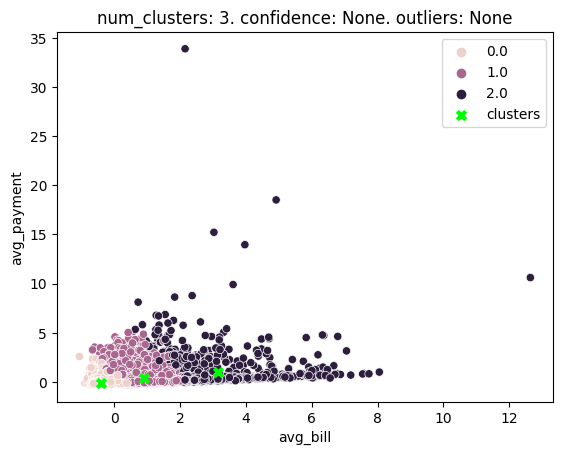

In [334]:
cluster_plot(3, None, CLUSTER_SEED, None)

                   datapoint_index
datapoint_cluster                 
0                            14300
1                             1078
2                             4146


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: None. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

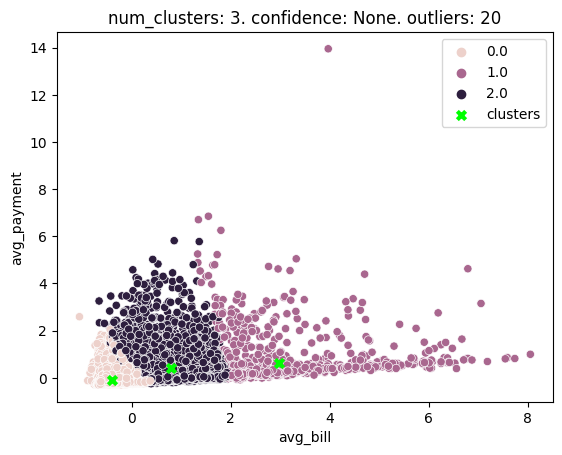

In [335]:
cluster_plot(3, None, CLUSTER_SEED, 20)

# Clustering under increased confidence cutoff needs more analysis

The dimension no longer explain the clusters

                   datapoint_index
datapoint_cluster                 
0                             3594
1                              974
2                            11209


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: 0.6. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

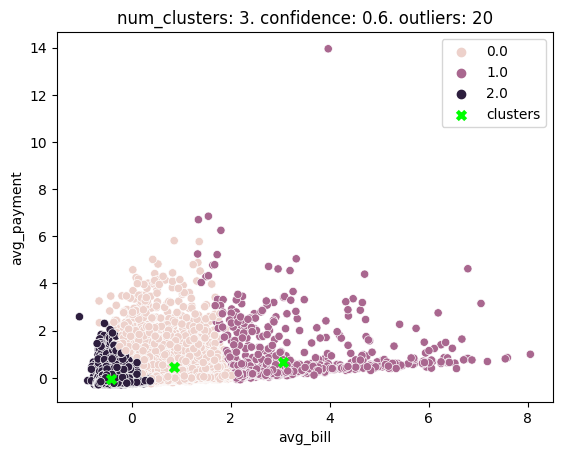

In [336]:
cluster_plot(3, 0.6, CLUSTER_SEED, 20)

                   datapoint_index
datapoint_cluster                 
0                             3140
1                              683
2                              577


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: 0.7. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

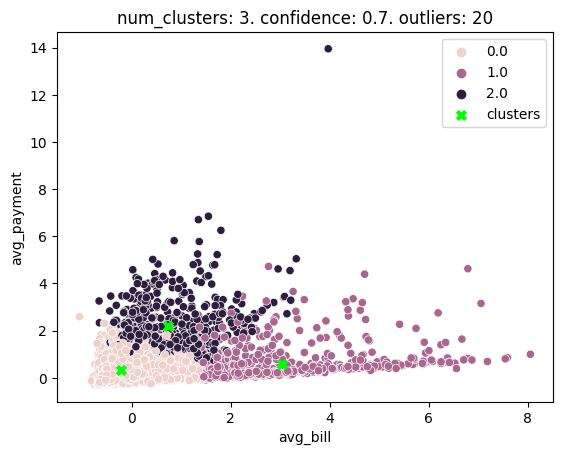

In [337]:
cluster_plot(3, 0.7, CLUSTER_SEED, 20)

                   datapoint_index
datapoint_cluster                 
0                              247
1                              205
2                             1500


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: 0.75. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

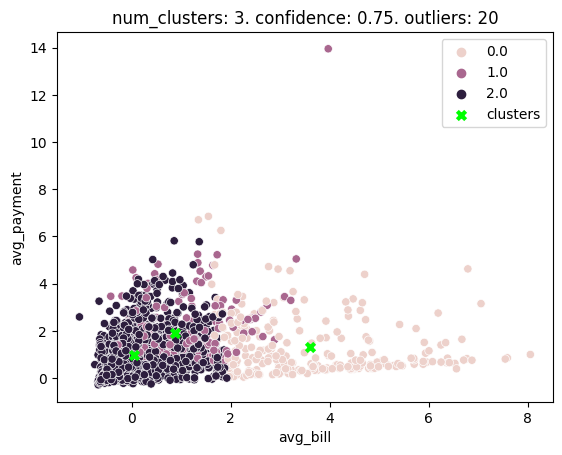

In [338]:
cluster_plot(3, 0.75, CLUSTER_SEED, 20)

                   datapoint_index
datapoint_cluster                 
0                              530
1                              198
2                              150


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: 0.8. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

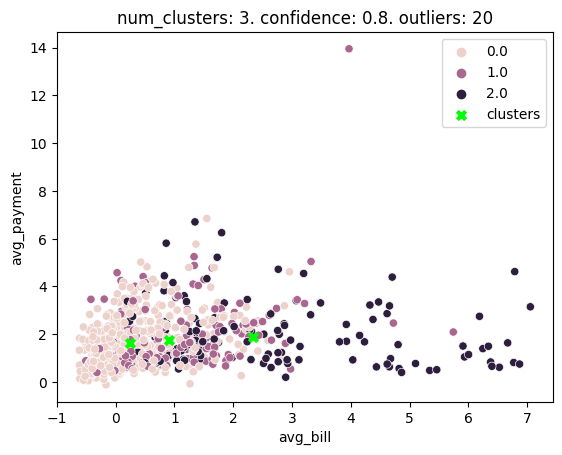

In [339]:
cluster_plot(3, 0.8, CLUSTER_SEED, 20)

                   datapoint_index
datapoint_cluster                 
0                               73
1                               73
2                               41


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: 0.9. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

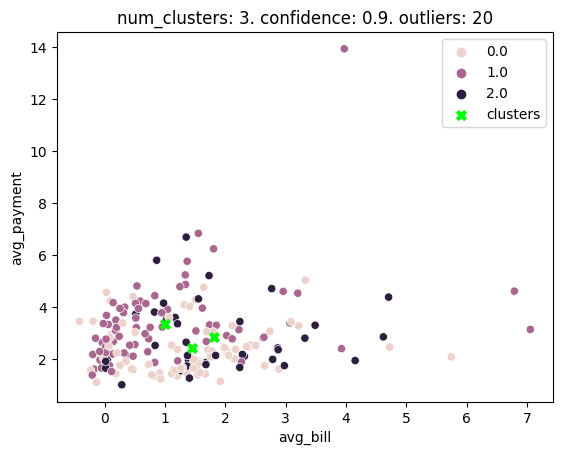

In [340]:
cluster_plot(3, 0.9, CLUSTER_SEED, 20)

# As we change the seed

Nothing changes :)

                   datapoint_index
datapoint_cluster                 
0                             3134
1                              684
2                              582


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: 0.7. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

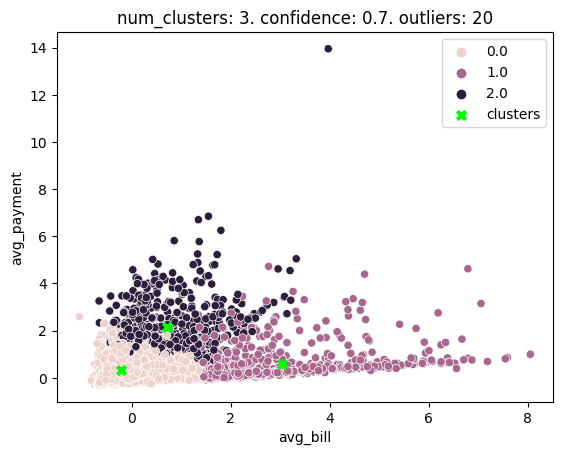

In [341]:
cluster_plot(3, 0.7, 0, 20)

                   datapoint_index
datapoint_cluster                 
0                              682
1                             3140
2                              578


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: 0.7. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

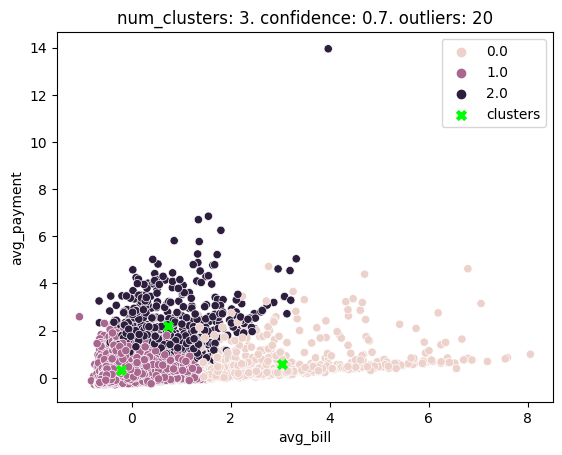

In [342]:
cluster_plot(3, 0.7, 1, 20)

                   datapoint_index
datapoint_cluster                 
0                             3141
1                              682
2                              577


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: 0.7. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

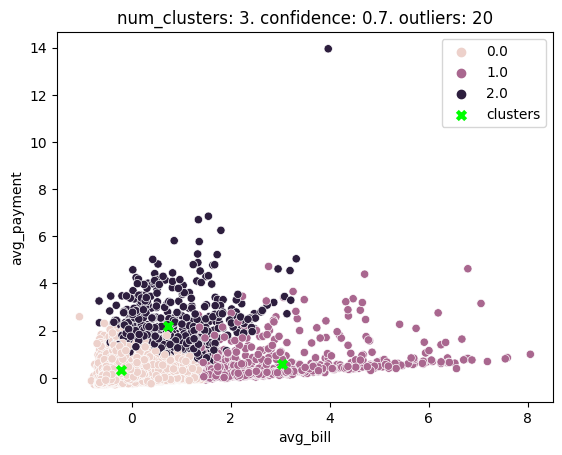

In [343]:
cluster_plot(3, 0.7, 2, 20)

# As we change number clusters

Starting at k=4, we need more analysis -- dimensions don't explain difference anymore.

                   datapoint_index
datapoint_cluster                 
0                             4400


<AxesSubplot: title={'center': 'num_clusters: 1. confidence: 0.7. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

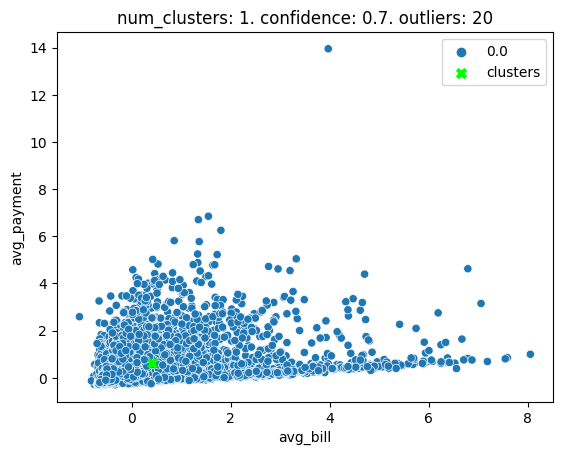

In [344]:
cluster_plot(1, 0.7, CLUSTER_SEED, 20)

                   datapoint_index
datapoint_cluster                 
0                              873
1                             3527


<AxesSubplot: title={'center': 'num_clusters: 2. confidence: 0.7. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

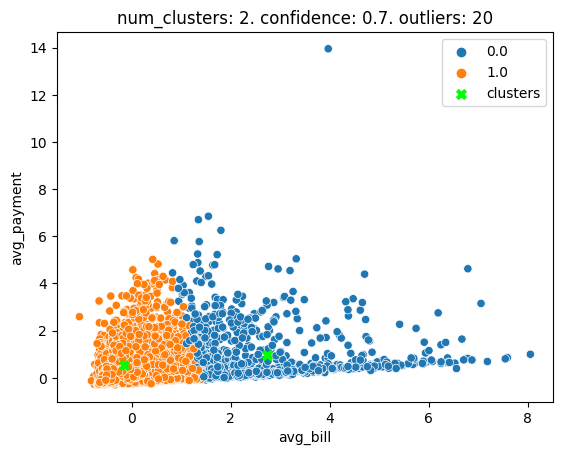

In [345]:
cluster_plot(2, 0.7, CLUSTER_SEED, 20)

                   datapoint_index
datapoint_cluster                 
0                             3140
1                              683
2                              577


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: 0.7. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

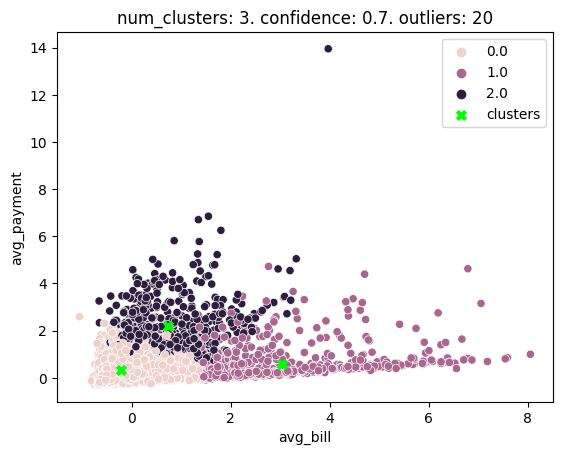

In [346]:
cluster_plot(3, 0.7, CLUSTER_SEED, 20)

                   datapoint_index
datapoint_cluster                 
0                             2998
1                              672
2                              205
3                              525


<AxesSubplot: title={'center': 'num_clusters: 4. confidence: 0.7. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

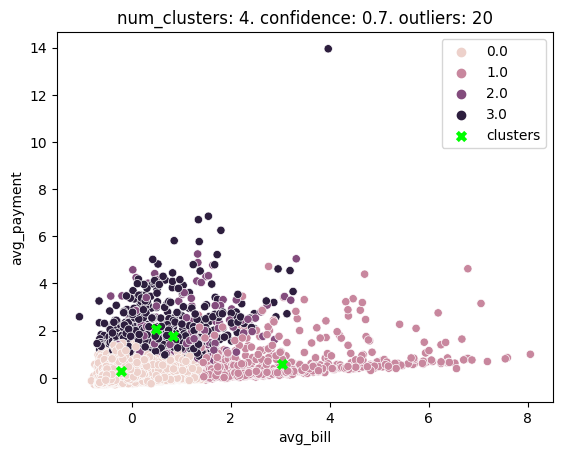

In [347]:
cluster_plot(4, 0.7, CLUSTER_SEED, 20)

# High confidence clusters

The average columns don't explain the difference, but PAY_AMT1 and PAY_AMT2 do.

This also holds for confidence 0.9.

                   datapoint_index
datapoint_cluster                 
0                              530
1                              198
2                              150


<AxesSubplot: title={'center': 'num_clusters: 3. confidence: 0.8. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

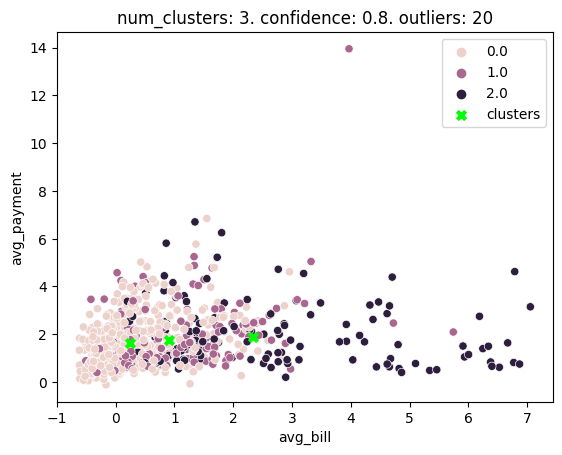

In [350]:
cluster_plot(3, 0.8, CLUSTER_SEED, 20)

In [364]:
clusters, dataset = generate_clusters(3, 0.8, CLUSTER_SEED, outlier=20)
cluster_centers = pd.DataFrame(columns=DATASET_COLUMNS, data=clusters.cluster_centers)
cluster_centers

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1.805324,0.082017,-0.466590,-0.399186,-0.379841,-0.335032,-0.308621,-0.316688,0.057350,0.033884,0.059819,0.244567,0.473052,0.572822,1.381941,1.142763,1.884476,1.977605,1.754782,1.748420
1,0.869149,-0.041164,-0.429229,-0.399186,-0.320730,-0.313447,-0.294547,-0.260212,0.197266,1.484398,1.130153,0.997587,0.843098,0.764581,7.800851,0.640533,0.610929,0.345617,0.408152,0.628432
2,1.740708,0.157070,-0.434010,-0.357609,-0.384614,-0.287435,-0.290044,-0.298051,1.630803,1.389688,3.022006,2.864279,2.629128,2.504804,0.780608,6.097747,1.653289,0.747092,0.815467,1.280857


Text(0.5, 1.0, 'Only True Positives')

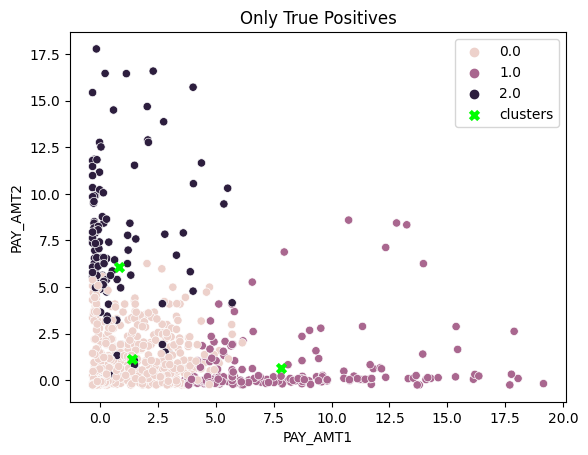

In [363]:
viz_data = ADAPTER.transform(dataset).copy()
viz_data['pos_proba'] = pos_proba
viz_data['classification'] = MODEL.predict(dataset)

viz_data['datapoint_index'] = viz_data.index
viz_data = viz_data.merge(clusters.cluster_assignments, how='left', on='datapoint_index')
viz_data = viz_data.drop(columns='datapoint_index')

viz_clusters = cluster_centers.copy()

sns.scatterplot(viz_data[(viz_data.Y == 1) & (viz_data.classification == 0)], x='PAY_AMT1', y='PAY_AMT2', hue='datapoint_cluster')
plt.scatter(viz_clusters['PAY_AMT1'], viz_clusters['PAY_AMT2'], marker='x', c='lime', linewidths=3, label='clusters')
plt.legend()
plt.title("Only True Positives")

## More clusters

                   datapoint_index
datapoint_cluster                 
0                              891
1                            11031
2                              789
3                             3066


<AxesSubplot: title={'center': 'num_clusters: 4. confidence: 0.6. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

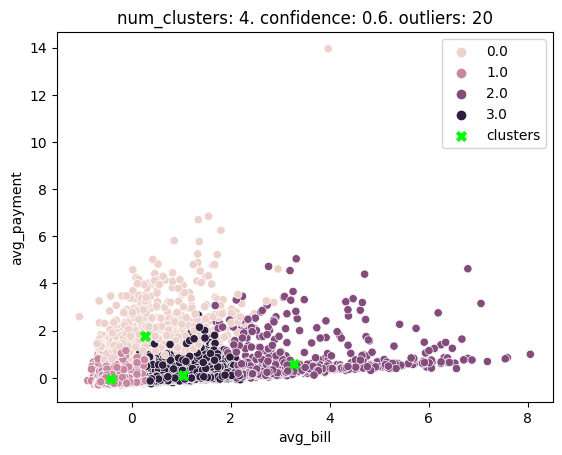

In [366]:
cluster_plot(4, 0.6, CLUSTER_SEED, 20)

                   datapoint_index
datapoint_cluster                 
0                             2998
1                              672
2                              205
3                              525


<AxesSubplot: title={'center': 'num_clusters: 4. confidence: 0.7. outliers: 20'}, xlabel='avg_bill', ylabel='avg_payment'>

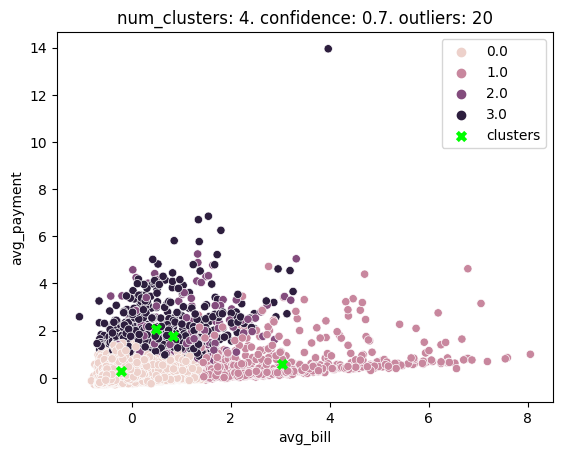

In [367]:
cluster_plot(4, 0.7, CLUSTER_SEED, 20)

In [368]:
clusters, dataset = generate_clusters(4, 0.7, CLUSTER_SEED, outlier=20)
cluster_centers = pd.DataFrame(columns=DATASET_COLUMNS, data=clusters.cluster_centers)
cluster_centers

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1.331472,-0.106805,-0.466878,-0.389617,-0.382927,-0.330349,-0.304903,-0.306431,-0.225040,-0.259803,-0.210270,-0.204959,-0.193167,-0.191345,0.346834,0.398957,0.280586,0.227292,0.212793,0.234414
1,1.676250,0.040802,-0.467114,-0.395474,-0.365791,-0.316528,-0.304475,-0.291728,2.956958,2.922308,3.041757,3.073828,3.136414,3.146054,0.514585,0.925479,0.476308,0.453527,0.524568,0.486310
2,0.867203,-0.008746,-0.392108,-0.399186,-0.322912,-0.314354,-0.295028,-0.248504,0.090669,1.400455,1.097664,0.971584,0.798709,0.693714,7.683461,0.910380,0.595346,0.357689,0.410245,0.679436
3,1.337134,0.123388,-0.449036,-0.396811,-0.355702,-0.329980,-0.308621,-0.295388,0.376852,0.223391,0.198224,0.446278,0.811515,0.957794,0.749277,0.945069,2.325978,2.997239,2.705008,2.773424


Cluster 0:


Text(0.5, 1.0, 'Only True Positives')

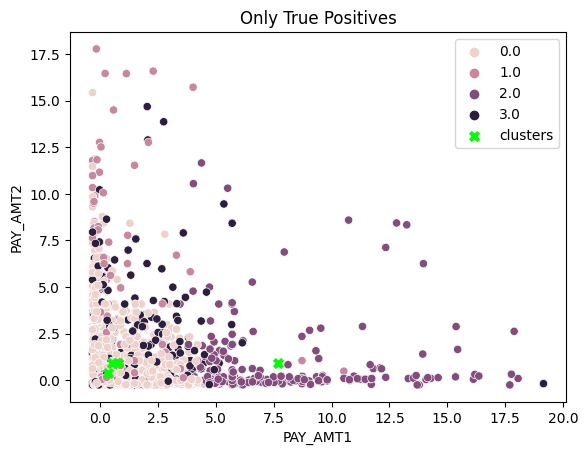

In [369]:
viz_data = ADAPTER.transform(dataset).copy()
viz_data['pos_proba'] = pos_proba
viz_data['classification'] = MODEL.predict(dataset)

viz_data['datapoint_index'] = viz_data.index
viz_data = viz_data.merge(clusters.cluster_assignments, how='left', on='datapoint_index')
viz_data = viz_data.drop(columns='datapoint_index')

viz_clusters = cluster_centers.copy()

sns.scatterplot(viz_data[(viz_data.Y == 1) & (viz_data.classification == 0)], x='PAY_AMT1', y='PAY_AMT2', hue='datapoint_cluster')
plt.scatter(viz_clusters['PAY_AMT1'], viz_clusters['PAY_AMT2'], marker='x', c='lime', linewidths=3, label='clusters')
plt.legend()
plt.title("Only True Positives")